In [2]:
import mdtraj as md
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from rocketshp.trajectory import load_trajectory
from rocketshp.trajectory import compute_generalized_correlation_lmi, compute_autocorrelation_DEPRECATED

# set seaborn theme
sns.set_theme(font_scale=1, style="white", palette="colorblind", context="talk")

In [3]:
# good examples:
## 1t7v_A -- two large domains
## 1tzw_A -- disordered ends
key = "1tzw_A"


sample_top = f"/mnt/home/ssledzieski/Projects/rocketshp/data/raw/atlas/{key[:2]}/{key}.pdb"
sample_traj = f"/mnt/home/ssledzieski/Projects/rocketshp/data/raw/atlas/{key[:2]}/{key}_prod_R2_fit.xtc"

traj = md.load_xtc(sample_traj, top=sample_top)

In [14]:
from rocketshp.plot import display_trajectory

display_trajectory(traj)

NGLWidget(max_frame=10000)

In [5]:
gci_lm = compute_generalized_correlation_lmi(sample_top, sample_traj)

/home/ssledzieski/miniforge3/envs/rocketshp/lib/python3.11/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


  0%|          | 0/10001 [00:00<?, ?it/s]

@>: total number of frames in trajectory file: 10001
@>: length of selected trajectory segment:     10001
@>: number of replicas:                     1
@>: using window length of 10001 simulation steps
@>: number or frames per replica:           10001
@>: first frame:                            0
@>: last frame:                             10001
@>: actual last frame:                      10001
@>: step:                                   1
@>: number of residues in selected atom group: 142
@>: number of nodes    in selected atom group: 142
@>: number of elements in selected atom group: 142
@>: sanity check pass: number of residues is same as number of nodes


@>: LMI/MI calculation ...
@>: begin frame: 0
@>: end   frame: 10001
@>: step:        1
@>: reshaping coordinates...
@>: values array has shape (10001, 142, 3)


100%|██████████| 10153/10153 [00:05<00:00, 1988.12it/s]

@>: computing and storing distances...


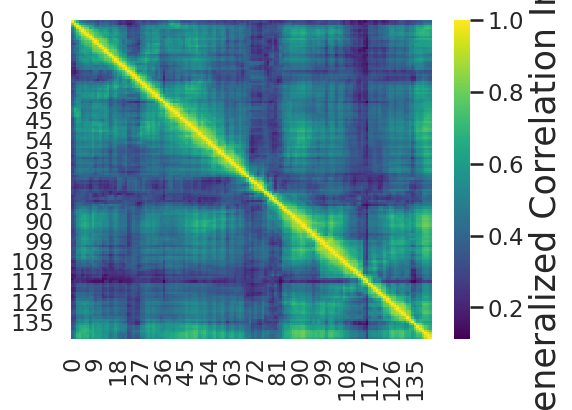

In [6]:
sns.heatmap(gci_lm, cmap="viridis", cbar_kws={'label': 'Generalized Correlation Index'})
plt.show()

In [7]:
from rocketshp.trajectory import compute_contacts
from itertools import combinations
from statsmodels.tsa.stattools import acf
import numpy as np

lag_list = [1, 10, 25, 50, 100, 250, 500, 1000]
contacts = compute_contacts(traj, normalized=True, ca_only=True)
correlations = np.zeros((contacts.shape[1], contacts.shape[1], len(lag_list)))
for c_i, c_j in combinations(range(contacts.shape[1]), 2):
    corrs_ = acf(contacts[:, c_i, c_j] - contacts[:, c_i, c_j].mean(), nlags=contacts.shape[0] - 1, fft=True)
    for l, lag in enumerate(lag_list): 
        correlations[c_i, c_j, l] = corrs_[lag]
        correlations[c_j, c_i, l] = corrs_[lag]

In [8]:
def center(x):
    return x - x.mean()

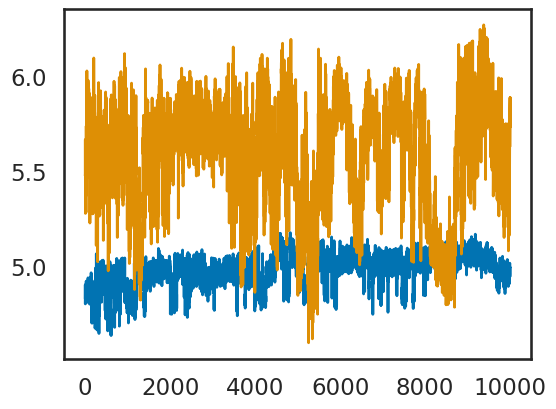

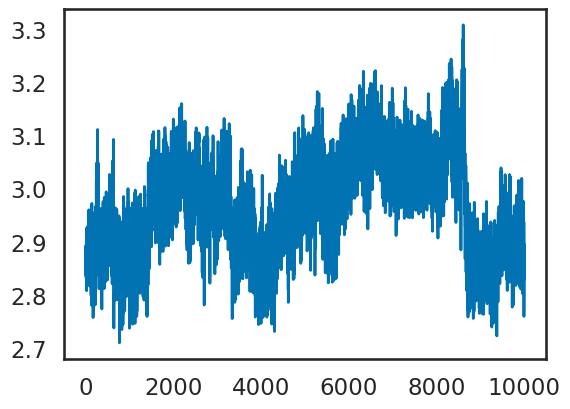

In [9]:


i = 126
j = 38
X = 0
Y = 1
Z = 2

plt.plot(traj.xyz[:, i, Z])
plt.plot(traj.xyz[:, j, Z])
plt.show()

plt.plot(contacts[:, i, j])
plt.show()

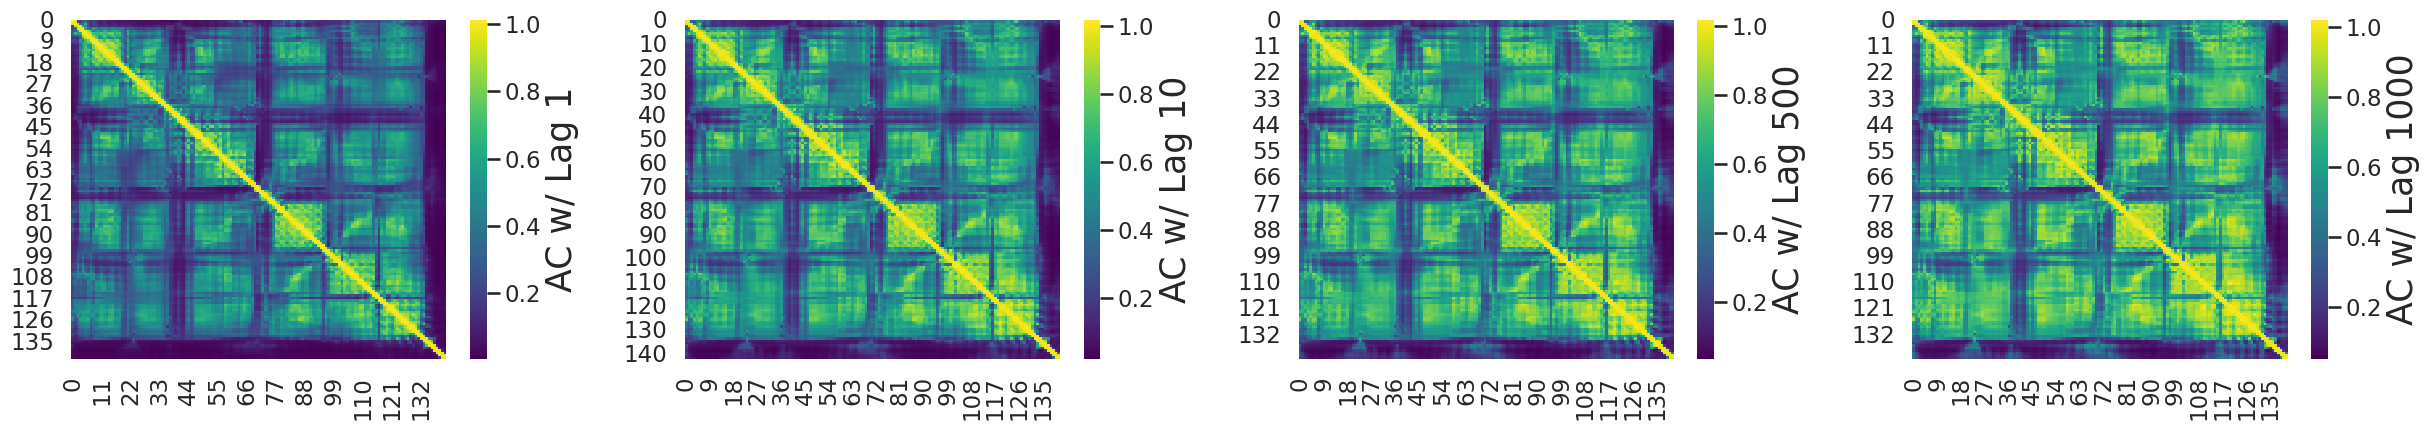

In [10]:
fig,ax = plt.subplots(1,4,figsize=(25,5))

for l, lag in enumerate([1,10,500,1000]):
    sns.heatmap(1 - correlations[:,:,l], cmap="viridis", cbar_kws={'label': 'AC w/ Lag {}'.format(lag)}, ax=ax[l])
plt.show()

---

In [11]:
from mdigest.core.parsetrajectory import MDS
from mdigest.core.correlation import DynCorr 

mds = MDS()
    
# set number of replicas
mds.set_num_replicas(1) # use 2 if you have 2 replicas.

#load topology and trajectory files into MDS class
mds.load_system(sample_top, sample_traj)

#align trajectory
mds.align_traj(selection='name CA')

# set selections for MDS class
mds.set_selection('protein and name CA', 'protein')

#stride trajectory
mds.stride_trajectory(initial=0, final=-1, step=5)

  0%|          | 0/10001 [00:00<?, ?it/s]

@>: total number of frames in trajectory file: 10001
@>: length of selected trajectory segment:     2000
@>: WARNING: the segmented trajectory has an uneven number of frames
@>: WARNING: 1 last frame/s will be excluded
@>: number of replicas:                     1
@>: using window length of 2000 simulation steps
@>: number or frames per replica:           2000
@>: first frame:                            0
@>: last frame:                             10001
@>: actual last frame:                      10000
@>: step:                                   5
@>: number of residues in selected atom group: 142
@>: number of nodes    in selected atom group: 142
@>: number of elements in selected atom group: 142


In [12]:
dyncorr = DynCorr(mds)
dyncorr.parse_dynamics(scale=True, normalize=True, LMI='gaussian', MI='knn_5_2', DCC=True, PCC=True, VERBOSE=True, COV_DISP=True)

@>: sanity check pass: number of residues is same as number of nodes
@> -- shape of coordinates matrix: (1, 2000, 142, 3)
@> -- shape of coordinates_allreplicas matrix: (1, 2000, 426)
@> -- shape of displacements_allreplicas matrix: (1, 2000, 426)
@> -- shape of disp_from_mean_allreplicas matrix: (1, 2000, 142)
@> -- shape of distances_allreplicas matrix: (1, 142, 142)
@> -- shape of covar_disp_allreplicas (1, 142, 142)
@> -- shape of dcc_allreplicas matrix: (1, 142, 142)
@> -- shape of pcc_allreplicas matrix: (1, 142, 142)


@>: LMI/MI calculation ...
@>: begin frame: 0
@>: end   frame: 10000
@>: step:        5
@>: compute covariance of displacements...
@>: reshaping coordinates...
@>: estimate == 2


100%|██████████| 10153/10153 [03:37<00:00, 46.60it/s]


@>: computing eigenvector centrality from mi matrix
@>: values array has shape (2000, 142, 3)


100%|██████████| 10153/10153 [00:00<00:00, 10901.08it/s]


@>: computing eigenvector centrality from lmi matrix
@>: computing and storing distances...
@>: computing normalized dynamical cross-correlation matrix
@>: computing pearson correlation matrix


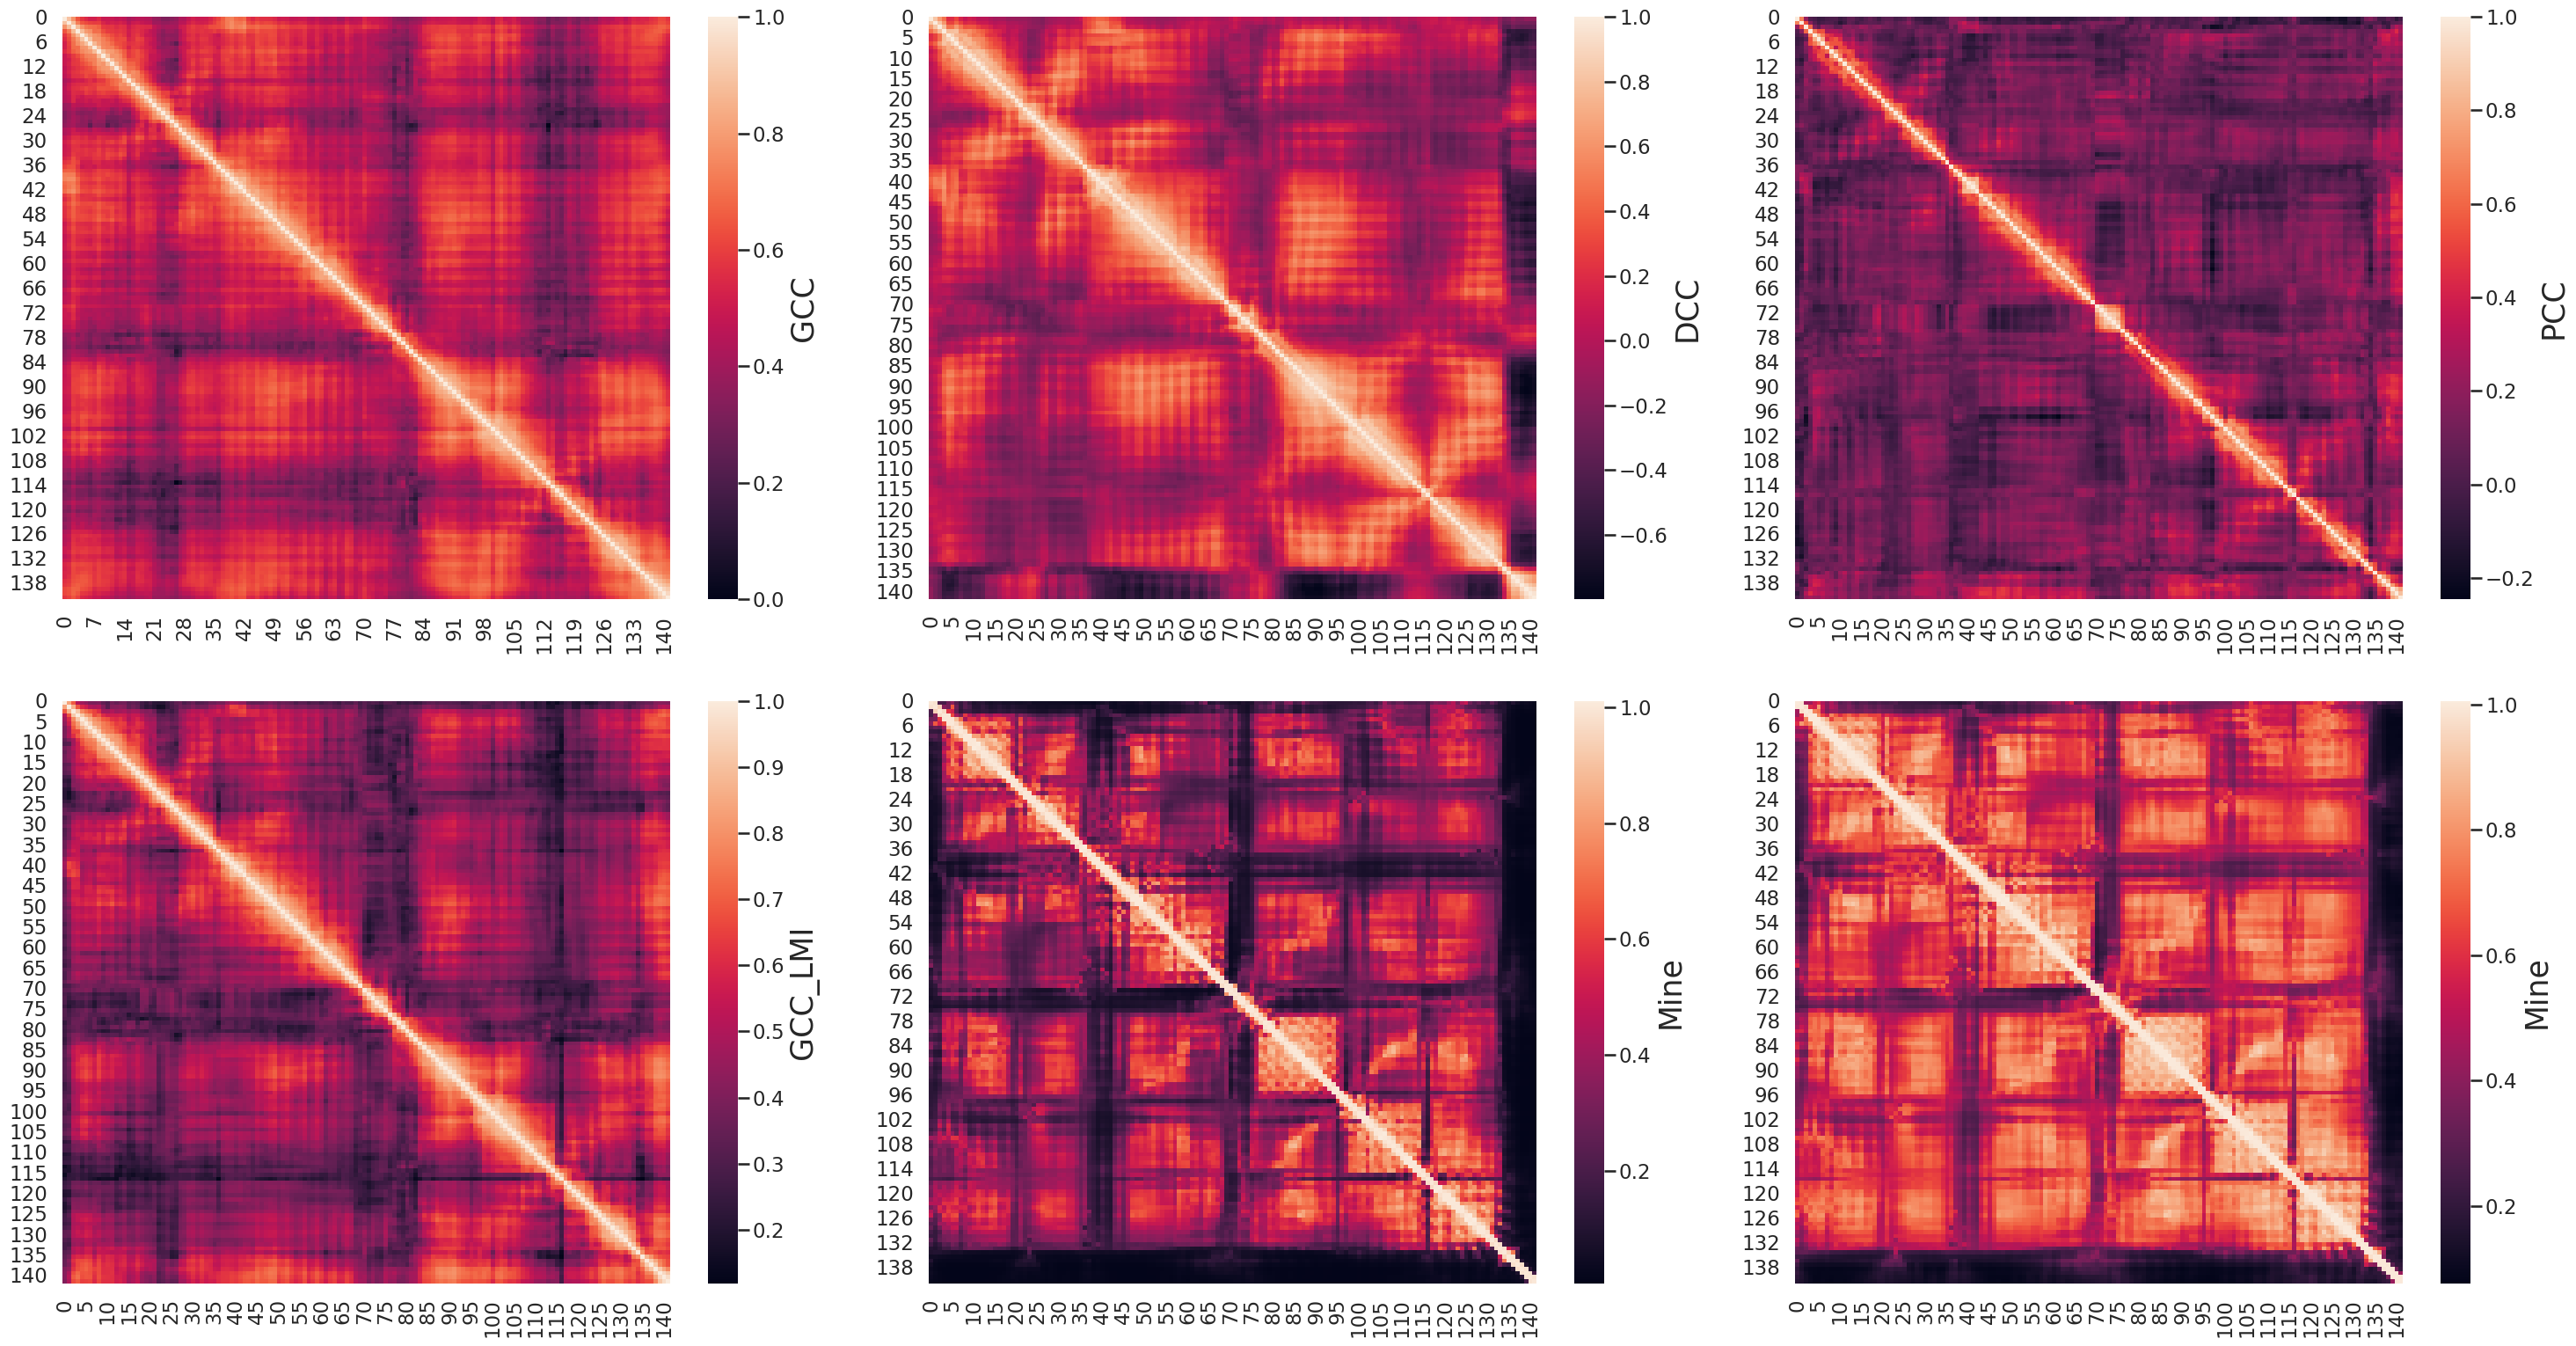

In [18]:
# set font scale
gcc = dyncorr.gcc_allreplicas["rep_0"]["gcc_mi"]
gcc_lmi = dyncorr.gcc_allreplicas["rep_0"]["gcc_lmi"]
dcc = dyncorr.dcc_allreplicas["rep_0"]
pcc = dyncorr.pcc_allreplicas["rep_0"]
ac_dep = compute_autocorrelation_DEPRECATED(traj)
fig,ax = plt.subplots(2,3,figsize=(30,16))
sns.heatmap(gcc, ax=ax[0][0], cbar_kws={'label': 'GCC'})
sns.heatmap(gcc_lmi, ax=ax[1][0], cbar_kws={'label': 'GCC_LMI'})
sns.heatmap(dcc, ax=ax[0][1], cbar_kws={'label': 'DCC'})
sns.heatmap(pcc, ax=ax[0][2], cbar_kws={'label': 'PCC'})
sns.heatmap(1 - ac_dep, ax=ax[1][1], cbar_kws={'label': 'Mine'})
sns.heatmap(np.sqrt(1 - ac_dep), ax=ax[1][2], cbar_kws={'label': 'Mine'})
plt.show()

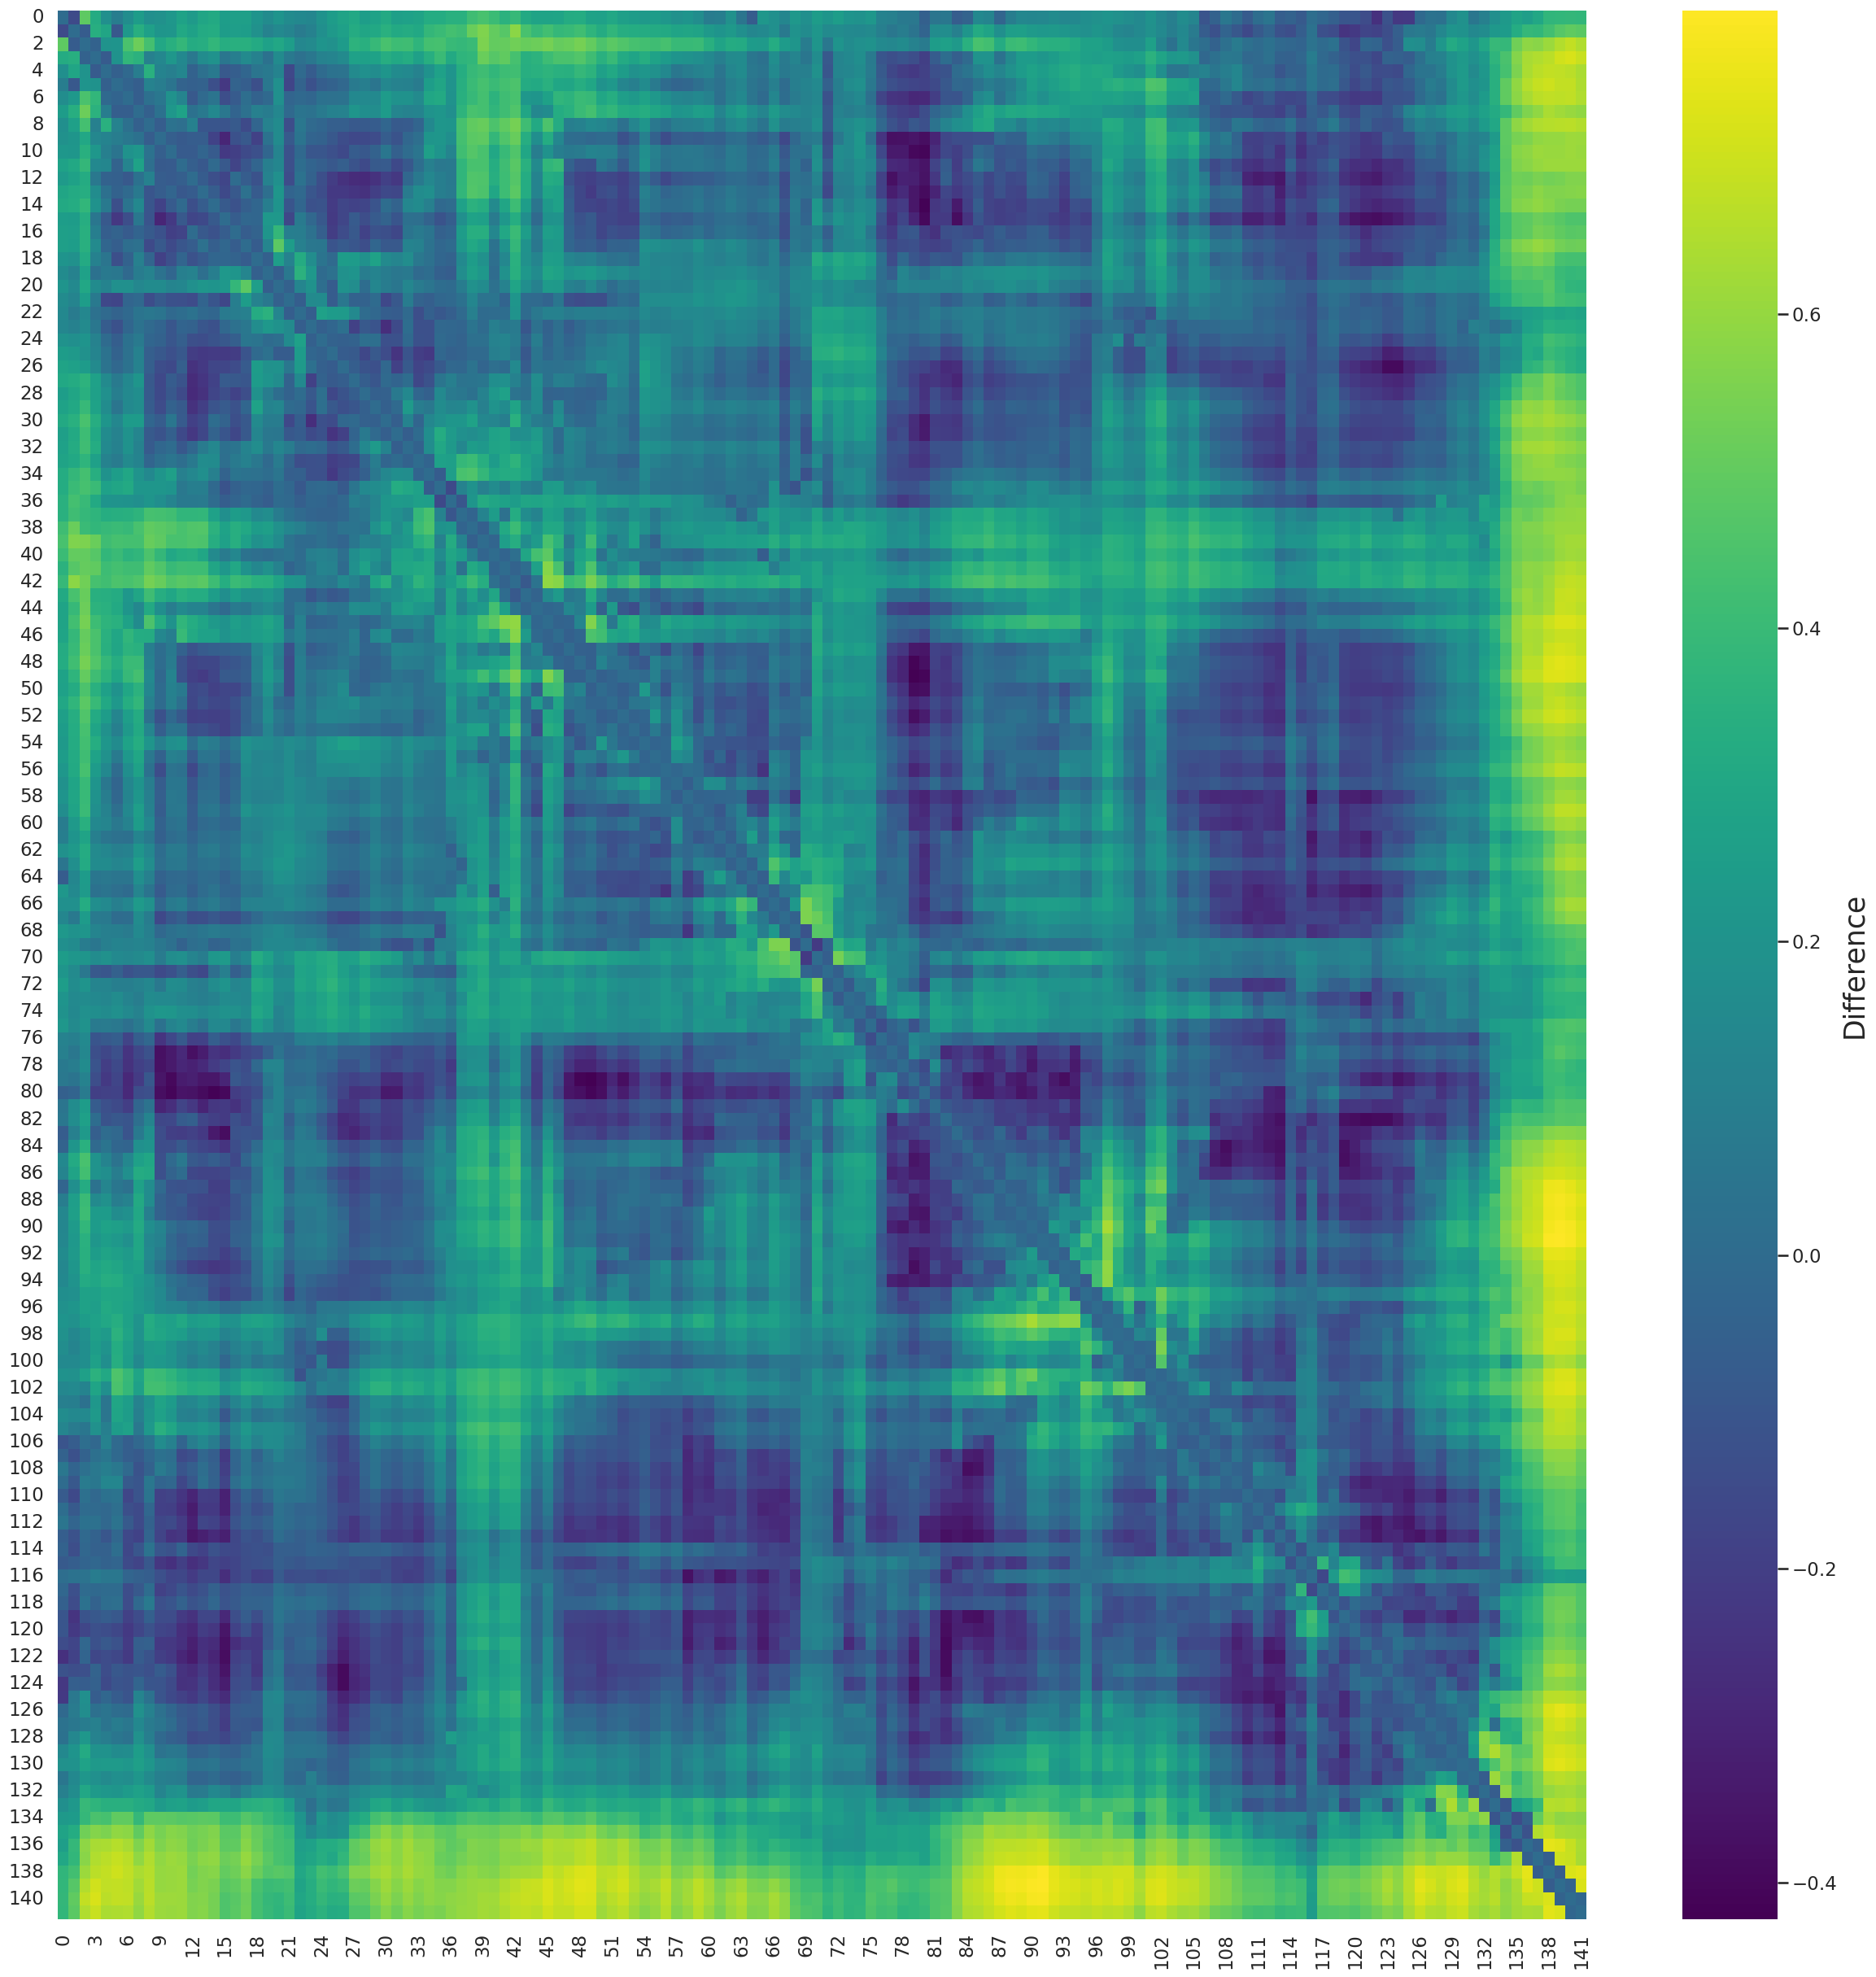

In [16]:
fig,ax = plt.subplots(1,1,figsize=(25,25))
difference = gcc_lmi - (1 - ac_dep)
sns.heatmap(difference, cmap="viridis", cbar_kws={'label': 'Difference'})
plt.show()

(array([2966., 2322., 3068., 3492., 2974., 2350., 1468.,  730.,  308.,
         486.]),
 array([0.00594353, 0.10644908, 0.20695464, 0.3074602 , 0.40796575,
        0.50847131, 0.60897687, 0.70948242, 0.80998798, 0.91049353,
        1.01099909]),
 <BarContainer object of 10 artists>)

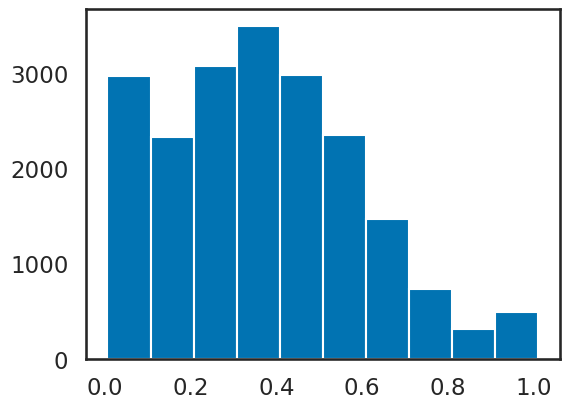

In [20]:
plt.hist((1 - ac_dep).flatten())

(array([1224.,  940., 1294., 1682., 2720., 3806., 3688., 2846., 1250.,
         714.]),
 array([0.07709428, 0.1699333 , 0.26277233, 0.35561135, 0.44845037,
        0.54128939, 0.63412842, 0.72696744, 0.81980646, 0.91264548,
        1.00548451]),
 <BarContainer object of 10 artists>)

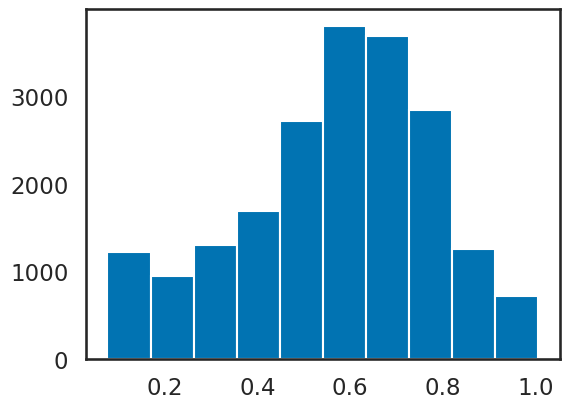

In [21]:
plt.hist(np.sqrt(1 - ac_dep).flatten())